# Training Neural Networks on High Dimensional Data using Random Projection
- Implementation of the [paper](https://link.springer.com/content/pdf/10.1007/s10044-018-0697-0.pdf) with the same name.

**High Dimensional Data?**

There is no specific condition under which data is classified as High Dimensional, but the dataset I am going to use, has 28395 features. That is very comfortably called as high dimensional data.In addition, this data doesnot have any spatial characteristic. So, this stops us from using convolutions and computer vision techniques.

Such data is usually seen in Bioinformatics, Social Media, Finance etc.

**Spatial Characteristics?**

Images are generally considered as high dimensional because for each image we have #(width)*#(height)*#(numberofchannels) pixels as features. But Images exhibit something known as Spatial Characteristic, which we will familiarize with in the coming few lines.

For example, suppose you are trying to classify images of shoes vs T-shirts from the Fashion MNIST [dataset](https://www.kaggle.com/zalando-research/fashionmnist).(As a side note MNIST images are not that big, but can be used to easily understand and experiment with concepts, on a basic level.) One of the first things we(humans), notice when asked to classify an image as a shoe or a T-shirt, is the shape. No matter, what color or size a shoe has, it has a distinctly different shape when compared to any T-shirt. This is called spatial Characteristic of the shoe. Even a neural network model tries to mimic our decision process i.e. using the shape to classify images. This is exactly what convolutions are used for i.e. identifying spatial characeristics of an image.

Here is an image of how a well trained neural network, extracts spatial features(in this case shape) out of an Fashion MNIST image in the process of classification of the image. This image is taken from one of the lecture videos of Coursera's TensorFlow in AI specialistaion.

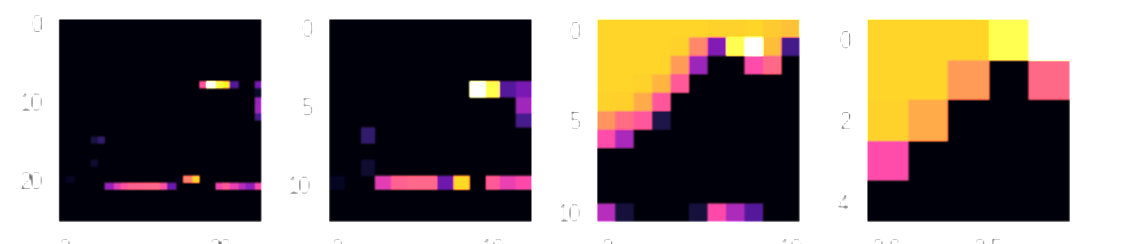

The above image depicts the output of 1st 2nd 3rd and 4th convolution layers respectively. Notice how the first convolution layer identifies the outline of a shoe and further convolution layers identify more resolved spatial characteristics. You can easily imagine this type of borderline for any shoe image taken at side viewing angles. So, this helps the neural network reduce number of features based on certain spatial characteristics guaranteed to be present in data like images.

But this is not true in case of our data, as our data is not an image.

**So Where is this data From?**

This data consists of 28395 gene expression values for just 200 plants. That is, with each sample having 28395 features, we only have 200 such samples. We are required to predict a single phenotype value for each plant from this data. **As far as we(non-biologists) are concerned, we have 200 samples and 28395 features per sample.** You can find the data [here](https://github.com/achillesposiedon/PapersImplemented/tree/master/RandomProjectionNeuralNetwork/Data).

**What is the problem with conventional regression Neural Networks?**

We are aware of the fact that, we need a huge amount of training data, i.e. training samples to be able to train a neural network. How much data you exactly need, is a question almost impossible to answer, because the amount of Data required depends upon a lot of factors, including application, complexity of the function you are trying to map, neural network architecture (though some might argue architecture can to some extent depend upon the available data) and so on. It is a generally accepted [fact](https://machinelearningmastery.com/much-training-data-required-machine-learning/) that the number of training samples have to be some x% larger than number of features, where x is in tens.

In our case we have a mere 200 samples against 28,395 features. Given that, our data does not look good to go for a direct regression neural network.

**So What Else?**
There are some 3-4 papers, which give us guidance as to how to overcome this task. I will be implementing one of those papers here.


**So what does the paper say?**

This paper relies on a lemma and here is the relevant quote from the paper.

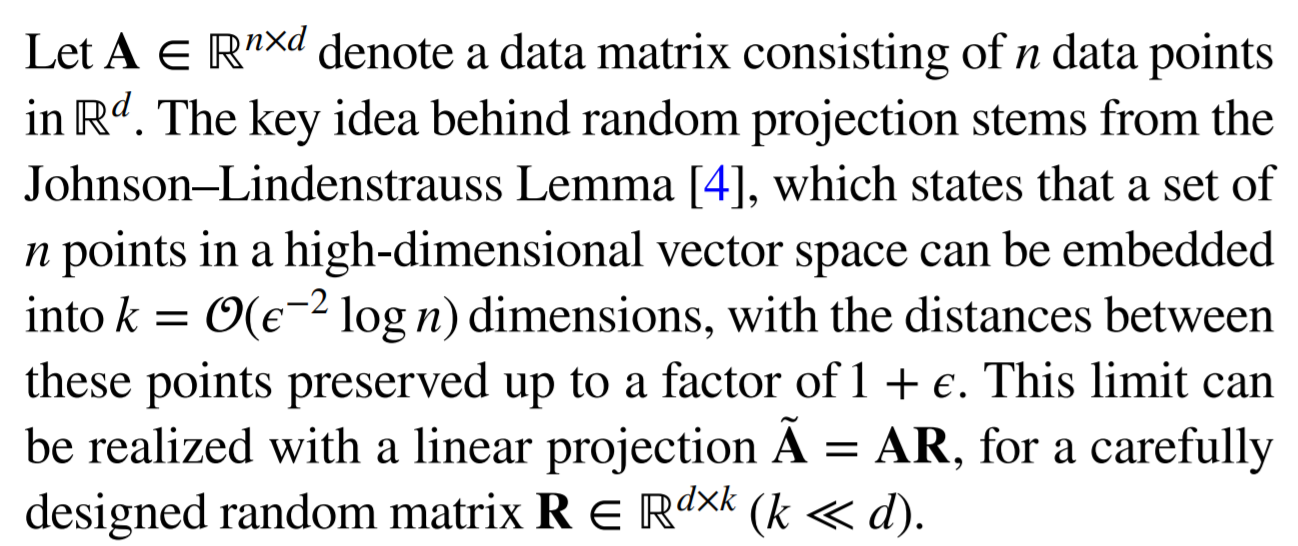

This in layman's terms implies that most of the structure of a very high dimensional data can be represented on a relatively very small dimensional space with very little loss, by multiplying the given data with a carefully designed Random Projection matrix.

The paper cites several constructions of RP matrix, including Gaussian, Achlioptas’, Li’s, subsampled randomized Hadamard transform (SRHT) and Count Sketch-based constructions.

The Achlioptas's construction is the one I am going to consider in this implementation.

The Achlioptas's RP matrix is defined as follows:
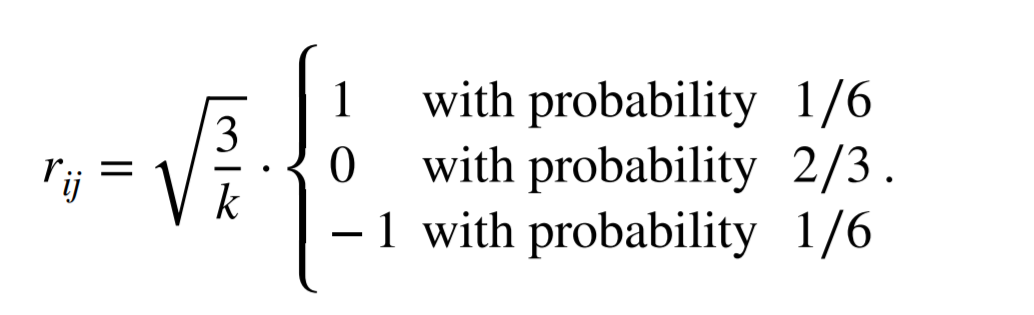

where k is the dimension of the smaller dimension space we are going to project the input data onto.

Now that we have understood to some extent, how, this RP Neural Network is going to work, let us First see How a regular neural network performs in the given task.

In [1]:
import torch

#imports necessary to define a neural network 
import torch.nn as nn
import torch.nn.functional as F

#ensure you are using GPU.
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
print(device)

dtype = torch.cuda.FloatTensor

cuda:0


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

trdt1=pd.read_csv('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Genotype\\TrainingGenotype.csv')
trdt=pd.read_csv('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Geneexpression0\\traingeneexpression.csv',header=None)
tstdt=pd.read_csv('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Geneexpression0\\testgeneexpression.csv',header=None)

tstdt=np.array(tstdt)
tstdt=np.transpose(tstdt)
tstdt=pd.DataFrame(tstdt)

trdt=np.array(trdt)
trdt=np.transpose(trdt)
trdt=pd.DataFrame(trdt)

results1=trdt1['Phenotype1']
results2=trdt1['Phenotype2']

testfeatures=tstdt

X=np.random.randn(30,6)
gole=tstdt
gole=pd.DataFrame(gole)

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
trdt=scaler.fit_transform(trdt.values)
trdt=pd.DataFrame(trdt)

scaler1=StandardScaler()
tstdt=scaler1.fit_transform(tstdt.values)
tstdt=pd.DataFrame(tstdt)

In [3]:
# convert matrices to pytorch tensors on gpu

trdttensor=torch.from_numpy(trdt.values).type(dtype)
results1tensor=torch.from_numpy(results1.values).type(dtype)

print(trdttensor.shape)
print(results1tensor.shape)

torch.Size([200, 28395])
torch.Size([200])


In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(28395,3200).cuda()
        self.fc3 = nn.Linear(3200,1).cuda()
        
    def forward(self, x):
        x = F.relu(self.fc1(x)).cuda()
        x = self.fc3(x).cuda()
        return x

net = Net()

#use gpu for all computations in model
net.cuda()
print(net)

Net(
  (fc1): Linear(in_features=28395, out_features=3200, bias=True)
  (fc3): Linear(in_features=3200, out_features=1, bias=True)
)


In [5]:
#trainingloop

import torch.optim as optim

net=Net()

lr = 0.01
batchsize=20

batches=len(trdttensor)/batchsize

epochs=1000

# create your optimizer
optimizer = optim.Adagrad(net.parameters(), lr=0.01)


for i in range(epochs):
    
    for j in range(int(batches)):
        
        #forward pass
        out=net(trdttensor[j:j+batchsize,:].type(dtype))

        #compute loss
        criterion = nn.MSELoss()
        loss = criterion(out,results1tensor[j:j+batchsize]).type(dtype)


        #backprop loss i.e. find dloss/dparam for each parameter and store.
        loss.backward(retain_graph=True)
        
        #clip gradients
        torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
        
        #use optimiser to update
        optimizer.step()
    c=nn.MSELoss()
    print(c(torch.reshape(net(trdttensor),[200]),results1tensor),i)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(8750.3350, device='cuda:0', grad_fn=<MseLossBackward>) 0
tensor(4182.0610, device='cuda:0', grad_fn=<MseLossBackward>) 1
tensor(2963.4177, device='cuda:0', grad_fn=<MseLossBackward>) 2
tensor(2426.8831, device='cuda:0', grad_fn=<MseLossBackward>) 3
tensor(2015.3982, device='cuda:0', grad_fn=<MseLossBackward>) 4
tensor(1665.8800, device='cuda:0', grad_fn=<MseLossBackward>) 5
tensor(1371.6389, device='cuda:0', grad_fn=<MseLossBackward>) 6
tensor(1137.2860, device='cuda:0', grad_fn=<MseLossBackward>) 7
tensor(959.6178, device='cuda:0', grad_fn=<MseLossBackward>) 8
tensor(825.8397, device='cuda:0', grad_fn=<MseLossBackward>) 9
tensor(732.7545, device='cuda:0', grad_fn=<MseLossBackward>) 10
tensor(660.8025, device='cuda:0', grad_fn=<MseLossBackward>) 11
tensor(611.8418, device='cuda:0', grad_fn=<MseLossBackward>) 12
tensor(571.9149, device='cuda:0', grad_fn=<MseLossBackward>) 13
tensor(539.3962, device='cuda:0', grad_fn=<MseLossBackward>) 14
tensor(515.4526, device='cuda:0', grad_fn=

tensor(1.0129, device='cuda:0', grad_fn=<MseLossBackward>) 258
tensor(1.0918, device='cuda:0', grad_fn=<MseLossBackward>) 259
tensor(1.1519, device='cuda:0', grad_fn=<MseLossBackward>) 260
tensor(1.0812, device='cuda:0', grad_fn=<MseLossBackward>) 261
tensor(1.1470, device='cuda:0', grad_fn=<MseLossBackward>) 262
tensor(1.2006, device='cuda:0', grad_fn=<MseLossBackward>) 263
tensor(1.2274, device='cuda:0', grad_fn=<MseLossBackward>) 264
tensor(1.1613, device='cuda:0', grad_fn=<MseLossBackward>) 265
tensor(1.0851, device='cuda:0', grad_fn=<MseLossBackward>) 266
tensor(1.1403, device='cuda:0', grad_fn=<MseLossBackward>) 267
tensor(1.0891, device='cuda:0', grad_fn=<MseLossBackward>) 268
tensor(1.3024, device='cuda:0', grad_fn=<MseLossBackward>) 269
tensor(1.2351, device='cuda:0', grad_fn=<MseLossBackward>) 270
tensor(1.1051, device='cuda:0', grad_fn=<MseLossBackward>) 271
tensor(0.9337, device='cuda:0', grad_fn=<MseLossBackward>) 272
tensor(0.9385, device='cuda:0', grad_fn=<MseLossBackwar

tensor(1.0280, device='cuda:0', grad_fn=<MseLossBackward>) 519
tensor(1.0278, device='cuda:0', grad_fn=<MseLossBackward>) 520
tensor(1.0276, device='cuda:0', grad_fn=<MseLossBackward>) 521
tensor(1.0274, device='cuda:0', grad_fn=<MseLossBackward>) 522
tensor(1.0271, device='cuda:0', grad_fn=<MseLossBackward>) 523
tensor(1.0269, device='cuda:0', grad_fn=<MseLossBackward>) 524
tensor(1.0267, device='cuda:0', grad_fn=<MseLossBackward>) 525
tensor(1.0265, device='cuda:0', grad_fn=<MseLossBackward>) 526
tensor(1.0263, device='cuda:0', grad_fn=<MseLossBackward>) 527
tensor(1.0260, device='cuda:0', grad_fn=<MseLossBackward>) 528
tensor(1.0258, device='cuda:0', grad_fn=<MseLossBackward>) 529
tensor(1.0256, device='cuda:0', grad_fn=<MseLossBackward>) 530
tensor(1.0255, device='cuda:0', grad_fn=<MseLossBackward>) 531
tensor(1.0252, device='cuda:0', grad_fn=<MseLossBackward>) 532
tensor(1.0250, device='cuda:0', grad_fn=<MseLossBackward>) 533
tensor(1.0248, device='cuda:0', grad_fn=<MseLossBackwar

tensor(1.0092, device='cuda:0', grad_fn=<MseLossBackward>) 650
tensor(1.0091, device='cuda:0', grad_fn=<MseLossBackward>) 651
tensor(1.0089, device='cuda:0', grad_fn=<MseLossBackward>) 652
tensor(1.0089, device='cuda:0', grad_fn=<MseLossBackward>) 653
tensor(1.0088, device='cuda:0', grad_fn=<MseLossBackward>) 654
tensor(1.0088, device='cuda:0', grad_fn=<MseLossBackward>) 655
tensor(1.0087, device='cuda:0', grad_fn=<MseLossBackward>) 656
tensor(1.0087, device='cuda:0', grad_fn=<MseLossBackward>) 657
tensor(1.0086, device='cuda:0', grad_fn=<MseLossBackward>) 658
tensor(1.0086, device='cuda:0', grad_fn=<MseLossBackward>) 659
tensor(1.0086, device='cuda:0', grad_fn=<MseLossBackward>) 660
tensor(1.0086, device='cuda:0', grad_fn=<MseLossBackward>) 661
tensor(1.0085, device='cuda:0', grad_fn=<MseLossBackward>) 662
tensor(1.0085, device='cuda:0', grad_fn=<MseLossBackward>) 663
tensor(1.0083, device='cuda:0', grad_fn=<MseLossBackward>) 664
tensor(1.0082, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.9890, device='cuda:0', grad_fn=<MseLossBackward>) 781
tensor(0.9891, device='cuda:0', grad_fn=<MseLossBackward>) 782
tensor(0.9885, device='cuda:0', grad_fn=<MseLossBackward>) 783
tensor(0.9887, device='cuda:0', grad_fn=<MseLossBackward>) 784
tensor(0.9882, device='cuda:0', grad_fn=<MseLossBackward>) 785
tensor(0.9882, device='cuda:0', grad_fn=<MseLossBackward>) 786
tensor(0.9877, device='cuda:0', grad_fn=<MseLossBackward>) 787
tensor(0.9879, device='cuda:0', grad_fn=<MseLossBackward>) 788
tensor(0.9871, device='cuda:0', grad_fn=<MseLossBackward>) 789
tensor(0.9873, device='cuda:0', grad_fn=<MseLossBackward>) 790
tensor(0.9869, device='cuda:0', grad_fn=<MseLossBackward>) 791
tensor(0.9868, device='cuda:0', grad_fn=<MseLossBackward>) 792
tensor(0.9863, device='cuda:0', grad_fn=<MseLossBackward>) 793
tensor(0.9864, device='cuda:0', grad_fn=<MseLossBackward>) 794
tensor(0.9858, device='cuda:0', grad_fn=<MseLossBackward>) 795
tensor(0.9854, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.9782, device='cuda:0', grad_fn=<MseLossBackward>) 912
tensor(0.9781, device='cuda:0', grad_fn=<MseLossBackward>) 913
tensor(0.9780, device='cuda:0', grad_fn=<MseLossBackward>) 914
tensor(0.9780, device='cuda:0', grad_fn=<MseLossBackward>) 915
tensor(0.9779, device='cuda:0', grad_fn=<MseLossBackward>) 916
tensor(0.9779, device='cuda:0', grad_fn=<MseLossBackward>) 917
tensor(0.9778, device='cuda:0', grad_fn=<MseLossBackward>) 918
tensor(0.9778, device='cuda:0', grad_fn=<MseLossBackward>) 919
tensor(0.9777, device='cuda:0', grad_fn=<MseLossBackward>) 920
tensor(0.9776, device='cuda:0', grad_fn=<MseLossBackward>) 921
tensor(0.9776, device='cuda:0', grad_fn=<MseLossBackward>) 922
tensor(0.9775, device='cuda:0', grad_fn=<MseLossBackward>) 923
tensor(0.9775, device='cuda:0', grad_fn=<MseLossBackward>) 924
tensor(0.9774, device='cuda:0', grad_fn=<MseLossBackward>) 925
tensor(0.9774, device='cuda:0', grad_fn=<MseLossBackward>) 926
tensor(0.9773, device='cuda:0', grad_fn=<MseLossBackwar

In [6]:
print(net(torch.from_numpy(trdt.values).type(dtype)))

tensor([[1.9931],
        [2.0318],
        [2.0399],
        [2.0683],
        [2.0839],
        [2.0028],
        [1.9945],
        [2.0597],
        [2.0555],
        [2.0335],
        [2.0362],
        [2.0844],
        [2.0534],
        [2.0720],
        [2.0386],
        [2.0542],
        [2.0577],
        [2.0573],
        [2.0499],
        [2.0547],
        [2.0124],
        [2.0186],
        [2.0459],
        [2.0364],
        [2.0416],
        [2.0695],
        [2.0415],
        [2.0389],
        [2.0271],
        [1.1156],
        [0.6907],
        [1.3573],
        [0.4286],
        [1.6417],
        [1.1683],
        [0.5699],
        [1.0049],
        [0.6146],
        [1.4106],
        [0.3019],
        [0.3761],
        [2.1805],
        [1.2070],
        [1.0031],
        [1.8537],
        [0.8805],
        [0.7997],
        [0.2791],
        [2.0448],
        [2.0394],
        [1.2948],
        [0.7466],
        [1.4898],
        [1.6825],
        [1.7262],
        [2

In [7]:
#Evaluation

import joblib
#golden standard
m=joblib.load('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Geneexpression0\\12.pkl')

pred=pd.DataFrame(m.predict(tstdt))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(pred,net(torch.from_numpy(tstdt.values).type(dtype)).cpu().detach().numpy()))

1.0894098549846931


So, we have seen that we get a mean squared error of 1.09, which is not very good, especially given that values are in the range of 1 to 2. That is almost 50% error, very high.

# Fixed Layer Random Projection Neural Network

**So what is Fixed Layer Random Projection neural network?**

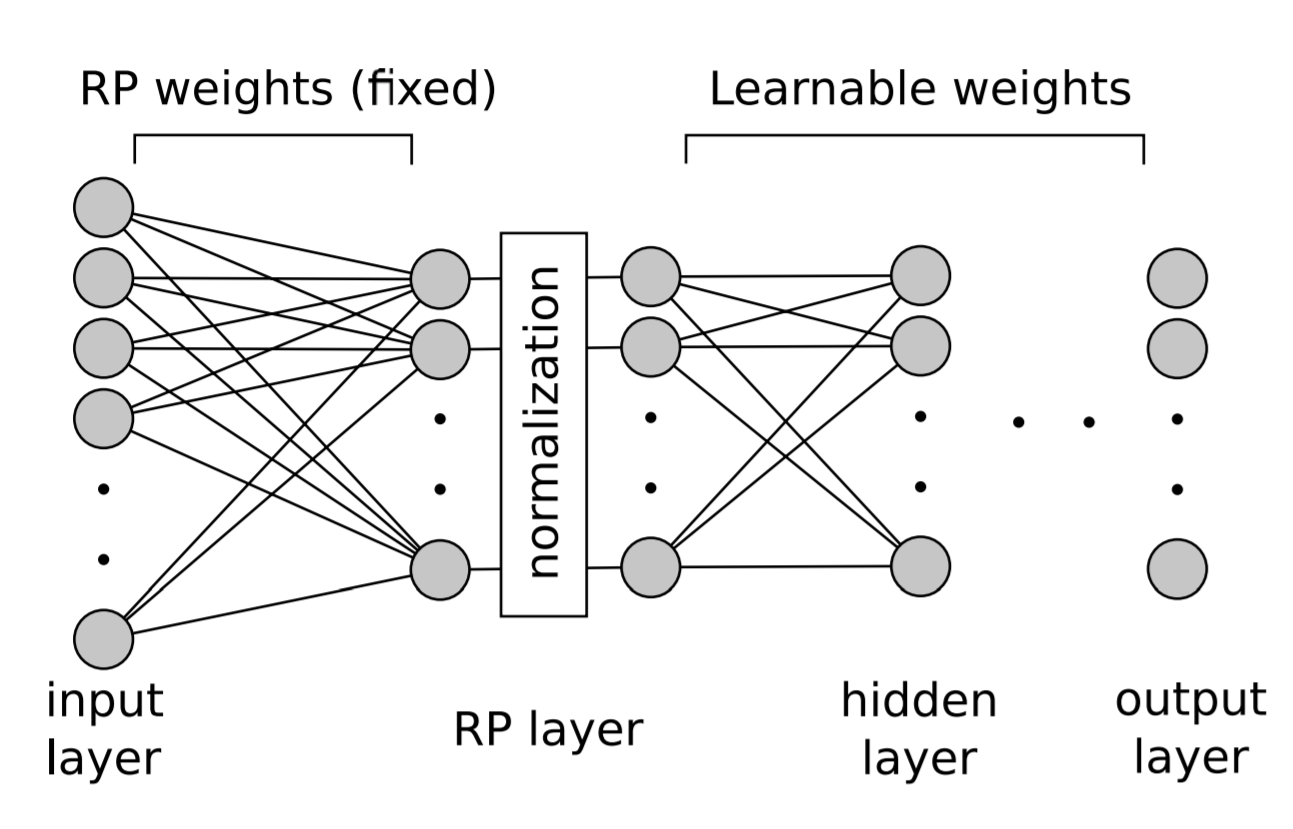

Here is an image to explain.

It is basically almost like preprocessing the given data and here instead of just reducing the range of values in data, we map the high dimensional data onto a lower dimensional space with the help of a Random Projection Matrix. In this particular variation of the Random Projection Neural Network, we treat the values inside Random Projection Matrix as untrainable i.e. fixed. After mapping the given data onto a smaller dimensional space, we normalise the data and then feed our smaller dimensional data into a conventional regression neural network.

In [5]:
# first fix the layer dimension after input layer
import random
import math

input_dim=28395
random_projection_layer_dim= 1000

def generatelisrandommatrix(input_dim,random_projection_layer_dim):
    
    size_0=input_dim
    size_1=random_projection_layer_dim
    
    matr=np.zeros([size_0,size_1])
    
    for i in range(size_0):
        m=[]
        for j in range(size_1):
            x=random.uniform(0,1)
            if x<(1/6):
                matr[i,j]=(1*math.sqrt((3/size_1)))
            
            if x>(1/6):
                if x<(1-1/6):
                    matr[i,j]=(0)
                
            if x>((1)-(1/6)):
                matr[i,j]=(-1*math.sqrt((3/size_1)))
    
    return matr


In [6]:
#Map the input into the smaller dimension of random_projection_layer using the generated Achilopta's  random projection matrix

randmatr=generatelisrandommatrix(28395,1000)
projectedtrdt=np.dot(trdt.values,randmatr)

#Normalise the projected data, not batch normalisation because, we are not fine tuning random projection layer weights

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
normalisedprojection=scaler.fit_transform(projectedtrdt)

In [7]:
#convert this numpy array to tensor
projectiontensor=torch.from_numpy(normalisedprojection).type(dtype)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(1000,320).cuda()
        self.fc6 = nn.Linear(320,1).cuda()
        
    def forward(self, x):
        x = F.relu(self.fc1(x)).cuda()
        x = self.fc6(x).cuda()
        return x

net = Net()

#use gpu for all computations in model
net.cuda()
print(net)

Net(
  (fc1): Linear(in_features=1000, out_features=320, bias=True)
  (fc6): Linear(in_features=320, out_features=1, bias=True)
)


In [8]:
#trainingloop

import torch.optim as optim

net1=Net()

lr = 0.001
batchsize=20

batches=len(projectiontensor)/batchsize

epochs=1000

# create your optimizer
optimizer = optim.Adam(net1.parameters(), lr)


for i in range(epochs):
    
    for j in range(int(batches)):
        
        #forward pass
        out=net1(projectiontensor[j:j+batchsize,:].type(dtype))

        #compute loss
        criterion = nn.MSELoss()
        loss = criterion(out,results1tensor[j:j+batchsize]).type(dtype)


        #backprop loss i.e. find dloss/dparam for each parameter and store.
        loss.backward(retain_graph=True)

        #clip gradients
        torch.nn.utils.clip_grad_norm_(net1.parameters(), 10.0)
        
        #use optimiser to update
        optimizer.step()
    c=nn.MSELoss()
    print(c(torch.reshape(net1(projectiontensor),[200]),results1tensor),i)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.2253, device='cuda:0', grad_fn=<MseLossBackward>) 0
tensor(3.2549, device='cuda:0', grad_fn=<MseLossBackward>) 1
tensor(2.8043, device='cuda:0', grad_fn=<MseLossBackward>) 2
tensor(2.1461, device='cuda:0', grad_fn=<MseLossBackward>) 3
tensor(2.6343, device='cuda:0', grad_fn=<MseLossBackward>) 4
tensor(1.6547, device='cuda:0', grad_fn=<MseLossBackward>) 5
tensor(2.3205, device='cuda:0', grad_fn=<MseLossBackward>) 6
tensor(1.9036, device='cuda:0', grad_fn=<MseLossBackward>) 7
tensor(1.6818, device='cuda:0', grad_fn=<MseLossBackward>) 8
tensor(2.0062, device='cuda:0', grad_fn=<MseLossBackward>) 9
tensor(1.3060, device='cuda:0', grad_fn=<MseLossBackward>) 10
tensor(1.9296, device='cuda:0', grad_fn=<MseLossBackward>) 11
tensor(1.1499, device='cuda:0', grad_fn=<MseLossBackward>) 12
tensor(1.7468, device='cuda:0', grad_fn=<MseLossBackward>) 13
tensor(1.0742, device='cuda:0', grad_fn=<MseLossBackward>) 14
tensor(1.5005, device='cuda:0', grad_fn=<MseLossBackward>) 15
tensor(1.0512, dev

tensor(0.9116, device='cuda:0', grad_fn=<MseLossBackward>) 134
tensor(1.0755, device='cuda:0', grad_fn=<MseLossBackward>) 135
tensor(0.8289, device='cuda:0', grad_fn=<MseLossBackward>) 136
tensor(1.0033, device='cuda:0', grad_fn=<MseLossBackward>) 137
tensor(0.8638, device='cuda:0', grad_fn=<MseLossBackward>) 138
tensor(0.8791, device='cuda:0', grad_fn=<MseLossBackward>) 139
tensor(1.1246, device='cuda:0', grad_fn=<MseLossBackward>) 140
tensor(0.8029, device='cuda:0', grad_fn=<MseLossBackward>) 141
tensor(0.9120, device='cuda:0', grad_fn=<MseLossBackward>) 142
tensor(1.0555, device='cuda:0', grad_fn=<MseLossBackward>) 143
tensor(0.8381, device='cuda:0', grad_fn=<MseLossBackward>) 144
tensor(1.0441, device='cuda:0', grad_fn=<MseLossBackward>) 145
tensor(0.8637, device='cuda:0', grad_fn=<MseLossBackward>) 146
tensor(0.8239, device='cuda:0', grad_fn=<MseLossBackward>) 147
tensor(1.1549, device='cuda:0', grad_fn=<MseLossBackward>) 148
tensor(0.8729, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7879, device='cuda:0', grad_fn=<MseLossBackward>) 265
tensor(0.9595, device='cuda:0', grad_fn=<MseLossBackward>) 266
tensor(1.0049, device='cuda:0', grad_fn=<MseLossBackward>) 267
tensor(0.8988, device='cuda:0', grad_fn=<MseLossBackward>) 268
tensor(0.8570, device='cuda:0', grad_fn=<MseLossBackward>) 269
tensor(1.0338, device='cuda:0', grad_fn=<MseLossBackward>) 270
tensor(0.8014, device='cuda:0', grad_fn=<MseLossBackward>) 271
tensor(0.8299, device='cuda:0', grad_fn=<MseLossBackward>) 272
tensor(1.0213, device='cuda:0', grad_fn=<MseLossBackward>) 273
tensor(0.8698, device='cuda:0', grad_fn=<MseLossBackward>) 274
tensor(0.9215, device='cuda:0', grad_fn=<MseLossBackward>) 275
tensor(0.8928, device='cuda:0', grad_fn=<MseLossBackward>) 276
tensor(0.8030, device='cuda:0', grad_fn=<MseLossBackward>) 277
tensor(0.9751, device='cuda:0', grad_fn=<MseLossBackward>) 278
tensor(1.0221, device='cuda:0', grad_fn=<MseLossBackward>) 279
tensor(0.9420, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7681, device='cuda:0', grad_fn=<MseLossBackward>) 395
tensor(0.9092, device='cuda:0', grad_fn=<MseLossBackward>) 396
tensor(0.7593, device='cuda:0', grad_fn=<MseLossBackward>) 397
tensor(0.8032, device='cuda:0', grad_fn=<MseLossBackward>) 398
tensor(0.8868, device='cuda:0', grad_fn=<MseLossBackward>) 399
tensor(0.7382, device='cuda:0', grad_fn=<MseLossBackward>) 400
tensor(0.8289, device='cuda:0', grad_fn=<MseLossBackward>) 401
tensor(0.8487, device='cuda:0', grad_fn=<MseLossBackward>) 402
tensor(0.7098, device='cuda:0', grad_fn=<MseLossBackward>) 403
tensor(0.8296, device='cuda:0', grad_fn=<MseLossBackward>) 404
tensor(0.8113, device='cuda:0', grad_fn=<MseLossBackward>) 405
tensor(0.7089, device='cuda:0', grad_fn=<MseLossBackward>) 406
tensor(0.8456, device='cuda:0', grad_fn=<MseLossBackward>) 407
tensor(0.7751, device='cuda:0', grad_fn=<MseLossBackward>) 408
tensor(0.7250, device='cuda:0', grad_fn=<MseLossBackward>) 409
tensor(0.8805, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7018, device='cuda:0', grad_fn=<MseLossBackward>) 526
tensor(0.8273, device='cuda:0', grad_fn=<MseLossBackward>) 527
tensor(0.7063, device='cuda:0', grad_fn=<MseLossBackward>) 528
tensor(0.7015, device='cuda:0', grad_fn=<MseLossBackward>) 529
tensor(0.8277, device='cuda:0', grad_fn=<MseLossBackward>) 530
tensor(0.7059, device='cuda:0', grad_fn=<MseLossBackward>) 531
tensor(0.7012, device='cuda:0', grad_fn=<MseLossBackward>) 532
tensor(0.8268, device='cuda:0', grad_fn=<MseLossBackward>) 533
tensor(0.7063, device='cuda:0', grad_fn=<MseLossBackward>) 534
tensor(0.7009, device='cuda:0', grad_fn=<MseLossBackward>) 535
tensor(0.8262, device='cuda:0', grad_fn=<MseLossBackward>) 536
tensor(0.7054, device='cuda:0', grad_fn=<MseLossBackward>) 537
tensor(0.6984, device='cuda:0', grad_fn=<MseLossBackward>) 538
tensor(0.8267, device='cuda:0', grad_fn=<MseLossBackward>) 539
tensor(0.7087, device='cuda:0', grad_fn=<MseLossBackward>) 540
tensor(0.6970, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7273, device='cuda:0', grad_fn=<MseLossBackward>) 663
tensor(0.7968, device='cuda:0', grad_fn=<MseLossBackward>) 664
tensor(0.8734, device='cuda:0', grad_fn=<MseLossBackward>) 665
tensor(0.7214, device='cuda:0', grad_fn=<MseLossBackward>) 666
tensor(0.7825, device='cuda:0', grad_fn=<MseLossBackward>) 667
tensor(0.8864, device='cuda:0', grad_fn=<MseLossBackward>) 668
tensor(0.7350, device='cuda:0', grad_fn=<MseLossBackward>) 669
tensor(0.7748, device='cuda:0', grad_fn=<MseLossBackward>) 670
tensor(0.8848, device='cuda:0', grad_fn=<MseLossBackward>) 671
tensor(0.7427, device='cuda:0', grad_fn=<MseLossBackward>) 672
tensor(0.7688, device='cuda:0', grad_fn=<MseLossBackward>) 673
tensor(0.8870, device='cuda:0', grad_fn=<MseLossBackward>) 674
tensor(0.7441, device='cuda:0', grad_fn=<MseLossBackward>) 675
tensor(0.7563, device='cuda:0', grad_fn=<MseLossBackward>) 676
tensor(0.8891, device='cuda:0', grad_fn=<MseLossBackward>) 677
tensor(0.7568, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7634, device='cuda:0', grad_fn=<MseLossBackward>) 801
tensor(0.6574, device='cuda:0', grad_fn=<MseLossBackward>) 802
tensor(0.6354, device='cuda:0', grad_fn=<MseLossBackward>) 803
tensor(0.7604, device='cuda:0', grad_fn=<MseLossBackward>) 804
tensor(0.6760, device='cuda:0', grad_fn=<MseLossBackward>) 805
tensor(0.6214, device='cuda:0', grad_fn=<MseLossBackward>) 806
tensor(0.7424, device='cuda:0', grad_fn=<MseLossBackward>) 807
tensor(0.6840, device='cuda:0', grad_fn=<MseLossBackward>) 808
tensor(0.6006, device='cuda:0', grad_fn=<MseLossBackward>) 809
tensor(0.7137, device='cuda:0', grad_fn=<MseLossBackward>) 810
tensor(0.6965, device='cuda:0', grad_fn=<MseLossBackward>) 811
tensor(0.5917, device='cuda:0', grad_fn=<MseLossBackward>) 812
tensor(0.6876, device='cuda:0', grad_fn=<MseLossBackward>) 813
tensor(0.7155, device='cuda:0', grad_fn=<MseLossBackward>) 814
tensor(0.5982, device='cuda:0', grad_fn=<MseLossBackward>) 815
tensor(0.6690, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.6007, device='cuda:0', grad_fn=<MseLossBackward>) 939
tensor(0.5301, device='cuda:0', grad_fn=<MseLossBackward>) 940
tensor(0.6300, device='cuda:0', grad_fn=<MseLossBackward>) 941
tensor(0.6202, device='cuda:0', grad_fn=<MseLossBackward>) 942
tensor(0.5192, device='cuda:0', grad_fn=<MseLossBackward>) 943
tensor(0.5925, device='cuda:0', grad_fn=<MseLossBackward>) 944
tensor(0.6464, device='cuda:0', grad_fn=<MseLossBackward>) 945
tensor(0.5407, device='cuda:0', grad_fn=<MseLossBackward>) 946
tensor(0.5717, device='cuda:0', grad_fn=<MseLossBackward>) 947
tensor(0.6658, device='cuda:0', grad_fn=<MseLossBackward>) 948
tensor(0.5720, device='cuda:0', grad_fn=<MseLossBackward>) 949
tensor(0.5511, device='cuda:0', grad_fn=<MseLossBackward>) 950
tensor(0.6595, device='cuda:0', grad_fn=<MseLossBackward>) 951
tensor(0.5965, device='cuda:0', grad_fn=<MseLossBackward>) 952
tensor(0.5273, device='cuda:0', grad_fn=<MseLossBackward>) 953
tensor(0.6256, device='cuda:0', grad_fn=<MseLossBackwar

In [9]:
print(net1(projectiontensor).type(dtype))

tensor([[2.1695],
        [2.0072],
        [2.1011],
        [1.9959],
        [2.2116],
        [2.0176],
        [2.0215],
        [2.2107],
        [2.0146],
        [2.1682],
        [2.1837],
        [2.2179],
        [2.0253],
        [2.0163],
        [2.1467],
        [2.0081],
        [2.1118],
        [2.2233],
        [2.0302],
        [2.2133],
        [2.1381],
        [2.0445],
        [2.2174],
        [2.1869],
        [2.0158],
        [2.2267],
        [2.0471],
        [2.1156],
        [2.0044],
        [1.4764],
        [1.7115],
        [1.2514],
        [1.0006],
        [1.5163],
        [1.5072],
        [0.8886],
        [1.1226],
        [1.2752],
        [1.8468],
        [0.9757],
        [0.8897],
        [1.9588],
        [0.9279],
        [1.2430],
        [1.8887],
        [1.1929],
        [1.4623],
        [1.4297],
        [1.4935],
        [1.7694],
        [1.5851],
        [1.1844],
        [1.8678],
        [1.8757],
        [1.6009],
        [2

In [10]:
#Map the test data also into the smaller dimension of random_projection_layer using the same 
#generated Achliopta's  random projection matrix

projectedtstdt=np.dot(tstdt.values,randmatr)

#Normalise the projected data, not batch normalisation because, we are not fine tuning random projection layer weights

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
normalisedprojectiontest=scaler.fit_transform(projectedtstdt)

projectiontesttensor=torch.from_numpy(normalisedprojectiontest).type(dtype)
print(net1(projectiontesttensor).type(dtype))

tensor([[1.8908],
        [1.8004],
        [1.3634],
        [1.2090],
        [1.3241],
        [1.5034],
        [1.1810],
        [2.2858],
        [1.6984],
        [1.7172],
        [1.4761],
        [1.0720],
        [1.2300],
        [1.3050],
        [2.3853],
        [1.3023],
        [1.1797],
        [1.7256],
        [1.2844],
        [1.7006],
        [0.9631],
        [1.1747],
        [1.4469],
        [0.8785],
        [1.5071],
        [1.7533],
        [1.8542],
        [1.6746],
        [2.4079],
        [0.8707]], device='cuda:0', grad_fn=<AddmmBackward>)


In [11]:
#Evaluation

import joblib
#Gold Standard
m=joblib.load('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Geneexpression0\\12.pkl')

pred=pd.DataFrame(m.predict(tstdt))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(pred,net1(projectiontesttensor).cpu().detach().numpy()))

0.5250404650424876


We can already see MSE became almost half of the previous MSE, even with just 320 hidden neurons as opposed to 3200 neurons in the previous conventional regression neural network.

# Fine Tuned Random Projection Neural Network

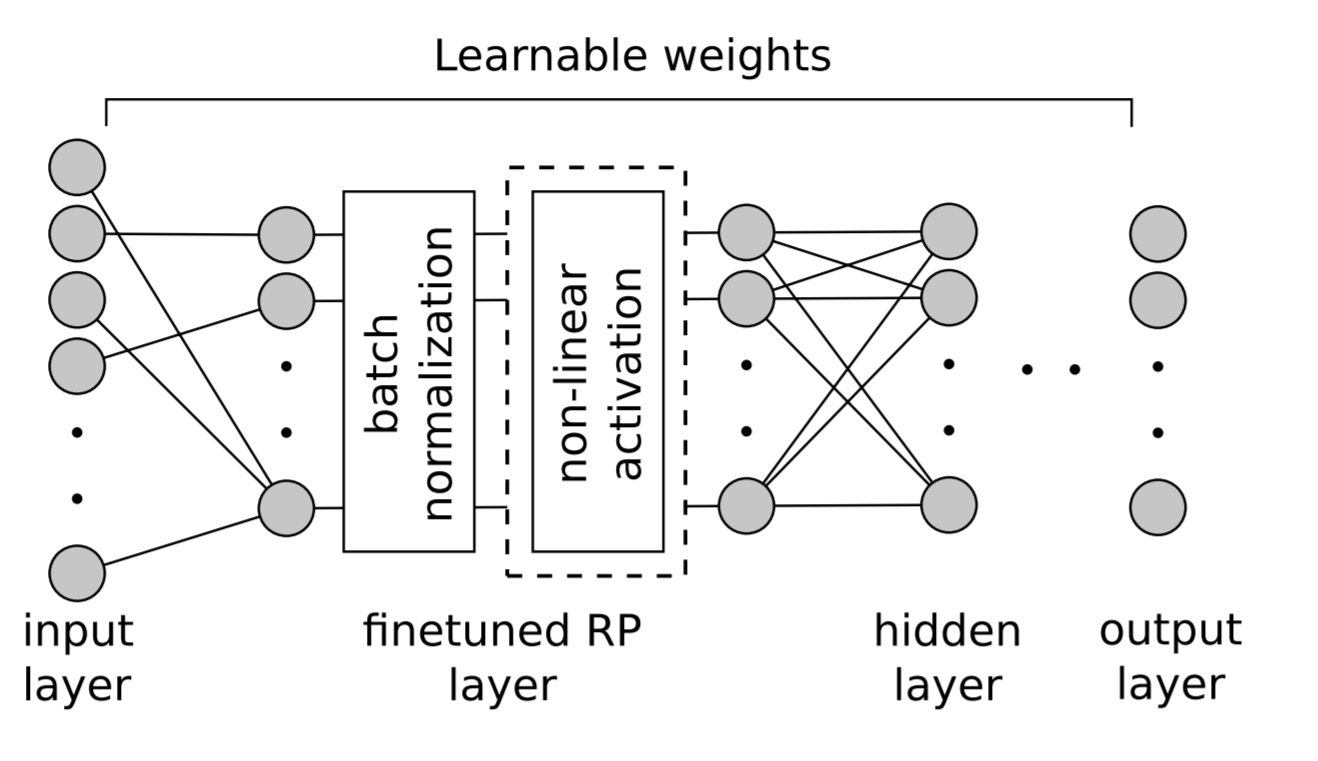

Here Random matrix is taken as weights between input layer and next layer, and only non-zero weights are updated(to save computational power).One more difference is batch normalisation is used after the random projection instead of whole data normalisation as was done in the fixed weights case, because random projection matrix is changing on the go.

In [12]:
# first fix the layer dimension after input layer
import random
import math

input_dim=28395
random_projection_layer_dim= 1000

def generatelisrandommatrix(input_dim,random_projection_layer_dim):
    
    size_0=input_dim
    size_1=random_projection_layer_dim
    
    matr=np.zeros([size_0,size_1])
    
    for i in range(size_0):
        m=[]
        for j in range(size_1):
            x=random.uniform(0,1)
            if x<(1/6):
                matr[i,j]=(1*math.sqrt((3/size_1)))
            
            if x>(1/6):
                if x<(1-1/6):
                    matr[i,j]=(0)
                
            if x>((1)-(1/6)):
                matr[i,j]=(-1*math.sqrt((3/size_1)))
    
    return matr

In [13]:
randmatr=generatelisrandommatrix(28395,1000)

In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        
        self.rand=nn.Linear(28395,1000).cuda()
        self.batchnorm=nn.BatchNorm1d(1000).cuda()
        self.fc1=nn.Linear(1000,320).cuda()
        self.fc6 = nn.Linear(320,1).cuda()
        
        #set weights as random projection matrix
        self.rand.weight.data = torch.transpose(torch.from_numpy(randmatr),0,1).type(dtype)
        
    def forward(self, x):
        x = self.rand(x).cuda()
        x = self.batchnorm(x).cuda()
        x = F.relu(x).cuda()
        x = F.relu(self.fc1(x)).cuda()        
        x = self.fc6(x).cuda()
        return x

net = Net()

#use gpu for all computations in model
net.cuda()
print(net)

Net(
  (rand): Linear(in_features=28395, out_features=1000, bias=True)
  (batchnorm): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1000, out_features=320, bias=True)
  (fc6): Linear(in_features=320, out_features=1, bias=True)
)


In [19]:
#trainingloop

import torch.optim as optim

net2=Net()

lr = 0.001
batchsize=20

batches=len(trdttensor)/batchsize

epochs=1000

# create your optimizer
optimizer = optim.Adam(net2.parameters(), lr)


for i in range(epochs):
    
    for j in range(int(batches)):
        
        #forward pass
        out=net2(trdttensor[j:j+batchsize,:].type(dtype))

        #compute loss
        criterion = nn.MSELoss()
        loss = criterion(out,results1tensor[j:j+batchsize]).type(dtype)


        #backprop loss i.e. find dloss/dparam for each parameter and store.
        loss.backward(retain_graph=True)

        #clip gradients
        torch.nn.utils.clip_grad_norm_(net2.parameters(), 10.0)
        
        #use optimiser to update
        optimizer.step()
    c=nn.MSELoss()
    print(c(torch.reshape(net2(trdttensor),[200]),results1tensor),i)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(1.2223, device='cuda:0', grad_fn=<MseLossBackward>) 0
tensor(2.3697, device='cuda:0', grad_fn=<MseLossBackward>) 1
tensor(1.0614, device='cuda:0', grad_fn=<MseLossBackward>) 2
tensor(1.2771, device='cuda:0', grad_fn=<MseLossBackward>) 3
tensor(0.9971, device='cuda:0', grad_fn=<MseLossBackward>) 4
tensor(0.8913, device='cuda:0', grad_fn=<MseLossBackward>) 5
tensor(1.1316, device='cuda:0', grad_fn=<MseLossBackward>) 6
tensor(0.8832, device='cuda:0', grad_fn=<MseLossBackward>) 7
tensor(0.8639, device='cuda:0', grad_fn=<MseLossBackward>) 8
tensor(1.4735, device='cuda:0', grad_fn=<MseLossBackward>) 9
tensor(0.9262, device='cuda:0', grad_fn=<MseLossBackward>) 10
tensor(1.0696, device='cuda:0', grad_fn=<MseLossBackward>) 11
tensor(1.0549, device='cuda:0', grad_fn=<MseLossBackward>) 12
tensor(1.0780, device='cuda:0', grad_fn=<MseLossBackward>) 13
tensor(1.0891, device='cuda:0', grad_fn=<MseLossBackward>) 14
tensor(0.8573, device='cuda:0', grad_fn=<MseLossBackward>) 15
tensor(0.8681, dev

tensor(0.9533, device='cuda:0', grad_fn=<MseLossBackward>) 132
tensor(0.8812, device='cuda:0', grad_fn=<MseLossBackward>) 133
tensor(0.7767, device='cuda:0', grad_fn=<MseLossBackward>) 134
tensor(1.0100, device='cuda:0', grad_fn=<MseLossBackward>) 135
tensor(0.8673, device='cuda:0', grad_fn=<MseLossBackward>) 136
tensor(0.7690, device='cuda:0', grad_fn=<MseLossBackward>) 137
tensor(0.8353, device='cuda:0', grad_fn=<MseLossBackward>) 138
tensor(0.9151, device='cuda:0', grad_fn=<MseLossBackward>) 139
tensor(0.7618, device='cuda:0', grad_fn=<MseLossBackward>) 140
tensor(0.7551, device='cuda:0', grad_fn=<MseLossBackward>) 141
tensor(0.8635, device='cuda:0', grad_fn=<MseLossBackward>) 142
tensor(0.7994, device='cuda:0', grad_fn=<MseLossBackward>) 143
tensor(0.7858, device='cuda:0', grad_fn=<MseLossBackward>) 144
tensor(0.8511, device='cuda:0', grad_fn=<MseLossBackward>) 145
tensor(0.7850, device='cuda:0', grad_fn=<MseLossBackward>) 146
tensor(0.7870, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.7501, device='cuda:0', grad_fn=<MseLossBackward>) 264
tensor(0.6873, device='cuda:0', grad_fn=<MseLossBackward>) 265
tensor(0.6760, device='cuda:0', grad_fn=<MseLossBackward>) 266
tensor(0.7666, device='cuda:0', grad_fn=<MseLossBackward>) 267
tensor(0.6937, device='cuda:0', grad_fn=<MseLossBackward>) 268
tensor(0.6831, device='cuda:0', grad_fn=<MseLossBackward>) 269
tensor(0.7059, device='cuda:0', grad_fn=<MseLossBackward>) 270
tensor(0.7425, device='cuda:0', grad_fn=<MseLossBackward>) 271
tensor(0.6808, device='cuda:0', grad_fn=<MseLossBackward>) 272
tensor(0.6726, device='cuda:0', grad_fn=<MseLossBackward>) 273
tensor(0.7584, device='cuda:0', grad_fn=<MseLossBackward>) 274
tensor(0.6895, device='cuda:0', grad_fn=<MseLossBackward>) 275
tensor(0.6765, device='cuda:0', grad_fn=<MseLossBackward>) 276
tensor(0.7085, device='cuda:0', grad_fn=<MseLossBackward>) 277
tensor(0.7327, device='cuda:0', grad_fn=<MseLossBackward>) 278
tensor(0.6755, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.6261, device='cuda:0', grad_fn=<MseLossBackward>) 396
tensor(0.5798, device='cuda:0', grad_fn=<MseLossBackward>) 397
tensor(0.5684, device='cuda:0', grad_fn=<MseLossBackward>) 398
tensor(0.5805, device='cuda:0', grad_fn=<MseLossBackward>) 399
tensor(0.6238, device='cuda:0', grad_fn=<MseLossBackward>) 400
tensor(0.5751, device='cuda:0', grad_fn=<MseLossBackward>) 401
tensor(0.5583, device='cuda:0', grad_fn=<MseLossBackward>) 402
tensor(0.5864, device='cuda:0', grad_fn=<MseLossBackward>) 403
tensor(0.6260, device='cuda:0', grad_fn=<MseLossBackward>) 404
tensor(0.5683, device='cuda:0', grad_fn=<MseLossBackward>) 405
tensor(0.5429, device='cuda:0', grad_fn=<MseLossBackward>) 406
tensor(0.5851, device='cuda:0', grad_fn=<MseLossBackward>) 407
tensor(0.6274, device='cuda:0', grad_fn=<MseLossBackward>) 408
tensor(0.5613, device='cuda:0', grad_fn=<MseLossBackward>) 409
tensor(0.5304, device='cuda:0', grad_fn=<MseLossBackward>) 410
tensor(0.5811, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.4550, device='cuda:0', grad_fn=<MseLossBackward>) 528
tensor(0.4662, device='cuda:0', grad_fn=<MseLossBackward>) 529
tensor(0.4268, device='cuda:0', grad_fn=<MseLossBackward>) 530
tensor(0.5704, device='cuda:0', grad_fn=<MseLossBackward>) 531
tensor(0.5233, device='cuda:0', grad_fn=<MseLossBackward>) 532
tensor(0.4709, device='cuda:0', grad_fn=<MseLossBackward>) 533
tensor(0.4741, device='cuda:0', grad_fn=<MseLossBackward>) 534
tensor(0.4729, device='cuda:0', grad_fn=<MseLossBackward>) 535
tensor(0.4585, device='cuda:0', grad_fn=<MseLossBackward>) 536
tensor(0.4189, device='cuda:0', grad_fn=<MseLossBackward>) 537
tensor(0.4394, device='cuda:0', grad_fn=<MseLossBackward>) 538
tensor(0.4720, device='cuda:0', grad_fn=<MseLossBackward>) 539
tensor(0.4513, device='cuda:0', grad_fn=<MseLossBackward>) 540
tensor(0.4197, device='cuda:0', grad_fn=<MseLossBackward>) 541
tensor(0.4074, device='cuda:0', grad_fn=<MseLossBackward>) 542
tensor(0.4473, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.3603, device='cuda:0', grad_fn=<MseLossBackward>) 660
tensor(0.3544, device='cuda:0', grad_fn=<MseLossBackward>) 661
tensor(0.3603, device='cuda:0', grad_fn=<MseLossBackward>) 662
tensor(0.3842, device='cuda:0', grad_fn=<MseLossBackward>) 663
tensor(0.3470, device='cuda:0', grad_fn=<MseLossBackward>) 664
tensor(0.3617, device='cuda:0', grad_fn=<MseLossBackward>) 665
tensor(0.3505, device='cuda:0', grad_fn=<MseLossBackward>) 666
tensor(0.3579, device='cuda:0', grad_fn=<MseLossBackward>) 667
tensor(0.3787, device='cuda:0', grad_fn=<MseLossBackward>) 668
tensor(0.3444, device='cuda:0', grad_fn=<MseLossBackward>) 669
tensor(0.3612, device='cuda:0', grad_fn=<MseLossBackward>) 670
tensor(0.3470, device='cuda:0', grad_fn=<MseLossBackward>) 671
tensor(0.3568, device='cuda:0', grad_fn=<MseLossBackward>) 672
tensor(0.3738, device='cuda:0', grad_fn=<MseLossBackward>) 673
tensor(0.3413, device='cuda:0', grad_fn=<MseLossBackward>) 674
tensor(0.3601, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.2502, device='cuda:0', grad_fn=<MseLossBackward>) 792
tensor(0.2817, device='cuda:0', grad_fn=<MseLossBackward>) 793
tensor(0.2476, device='cuda:0', grad_fn=<MseLossBackward>) 794
tensor(0.2578, device='cuda:0', grad_fn=<MseLossBackward>) 795
tensor(0.2576, device='cuda:0', grad_fn=<MseLossBackward>) 796
tensor(0.2502, device='cuda:0', grad_fn=<MseLossBackward>) 797
tensor(0.2283, device='cuda:0', grad_fn=<MseLossBackward>) 798
tensor(0.2445, device='cuda:0', grad_fn=<MseLossBackward>) 799
tensor(0.2596, device='cuda:0', grad_fn=<MseLossBackward>) 800
tensor(0.2618, device='cuda:0', grad_fn=<MseLossBackward>) 801
tensor(0.2526, device='cuda:0', grad_fn=<MseLossBackward>) 802
tensor(0.2773, device='cuda:0', grad_fn=<MseLossBackward>) 803
tensor(0.2649, device='cuda:0', grad_fn=<MseLossBackward>) 804
tensor(0.3176, device='cuda:0', grad_fn=<MseLossBackward>) 805
tensor(0.2399, device='cuda:0', grad_fn=<MseLossBackward>) 806
tensor(0.2301, device='cuda:0', grad_fn=<MseLossBackwar

tensor(0.1558, device='cuda:0', grad_fn=<MseLossBackward>) 924
tensor(0.1614, device='cuda:0', grad_fn=<MseLossBackward>) 925
tensor(0.1657, device='cuda:0', grad_fn=<MseLossBackward>) 926
tensor(0.1680, device='cuda:0', grad_fn=<MseLossBackward>) 927
tensor(0.1681, device='cuda:0', grad_fn=<MseLossBackward>) 928
tensor(0.1657, device='cuda:0', grad_fn=<MseLossBackward>) 929
tensor(0.1612, device='cuda:0', grad_fn=<MseLossBackward>) 930
tensor(0.1554, device='cuda:0', grad_fn=<MseLossBackward>) 931
tensor(0.1493, device='cuda:0', grad_fn=<MseLossBackward>) 932
tensor(0.1439, device='cuda:0', grad_fn=<MseLossBackward>) 933
tensor(0.1396, device='cuda:0', grad_fn=<MseLossBackward>) 934
tensor(0.1364, device='cuda:0', grad_fn=<MseLossBackward>) 935
tensor(0.1344, device='cuda:0', grad_fn=<MseLossBackward>) 936
tensor(0.1333, device='cuda:0', grad_fn=<MseLossBackward>) 937
tensor(0.1332, device='cuda:0', grad_fn=<MseLossBackward>) 938
tensor(0.1336, device='cuda:0', grad_fn=<MseLossBackwar

In [20]:
#Evaluation

import joblib

m=joblib.load('C:\\Users\\Ant Pc\\GitHub\\pROJ\\Geneexpression0\\12.pkl')

pred=pd.DataFrame(m.predict(tstdt))

from sklearn.metrics import mean_squared_error

tstdttensor=torch.from_numpy(tstdt.values).type(dtype).cuda()
print(mean_squared_error(pred,net2(tstdttensor).cpu().detach().numpy()))

0.03190409490732618


Whoa! This almost (1/30)th of the MSE of Conventional Regression Neural Network. So, this conncludes my implementation of this paper. Further, you can try changing the RP matrix and also experimenting with different values of smaller dimensional space.

So, next time you come across High dimensional non-spatial data, you know where to come.

See you next time. Cheers.